## Описание проекта

Проект для «Викишоп»
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.



## Цель проекта

Необходимо обучить модель, способну. классифицировать комментарии на позитивные и негативные. Метрика качества модели - *F1*, значение не меньше 0.75.


## План работы

1. Загрузка данных.
2. Предварительная обработка, очистка тектса и лемматизация.
3. Подготовка выборок для машинного обучения.
4. Векторизация.
5. Обучение моделей.
6. Проверка лучшей модели на тестовой выборке.

## Описание данных

В нашем распоряжении набор данных с разметкой о токсичности правок.

Данные находятся в файле `toxic_comments.csv` Столбец **text** в нём содержит текст комментария, а **toxic** — целевой признак.

## Подготовка

### Настройка окружения

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from pymystem3 import Mystem
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from tqdm.notebook import tqdm
tqdm.pandas()
import numba
from sklearn.pipeline import Pipeline
from joblib import parallel_backend, Parallel, delayed
from pandarallel import pandarallel
import multiprocessing
pandarallel.initialize()
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


### Загрузка и изучение данных

In [2]:
# загрузим данные
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
# посмотрим данные
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
# посмотрим основную информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
# проверим прпуски
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [6]:
# проверим на явные дубликаты
data.duplicated().sum()

0

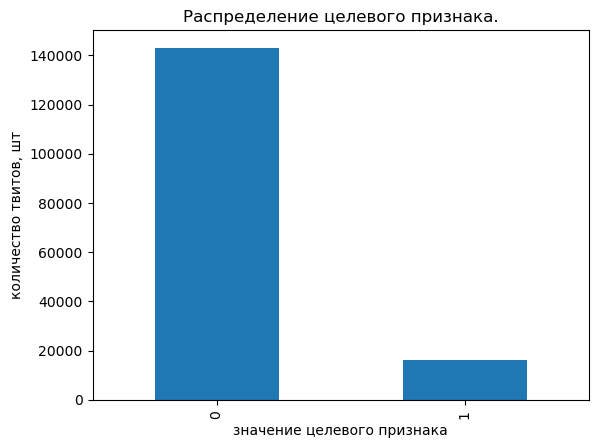

In [7]:
# посмотрим распределение целевого признака
data['toxic'].value_counts().plot(kind='bar');
plt.title('Распределение целевого признака.')
plt.xlabel('значение целевого признака')
plt.ylabel('количество твитов, шт')
plt.show()

In [8]:
# посмотрим распределение целевого признака в цифрах
print(data[data['toxic'] == 1].shape, data[data['toxic'] != 1].shape)

(16186, 3) (143106, 3)


Наблдюдаем дисбаланс целевого признака, соотношение токсичных комментариев к нетоксичным порядка 1:9. Наблюдаемые дисбаланс, но такое распределение может иметь органическую природу в данных. В линейной модели нужно будет учесть это при подборе гиперпараметров.

### Очистка текста

In [9]:
# переведем текст в нижний регистр
data['text'] = data['text'].str.lower()
data.head(5)

,Unnamed: 0,text,toxic
0,0,explanation\nwhy the edits made under my usern...,0
1,1,d'aww! he matches this background colour i'm s...,0
2,2,"hey man, i'm really not trying to edit war. it...",0
3,3,"""\nmore\ni can't make any real suggestions on ...",0
4,4,"you, sir, are my hero. any chance you remember...",0


In [10]:
# с помощью регулярных выражений избавимся от ссылок на сайты, имен пользователей и тегов, 
# методом strip удалим возможные пробелы в начале и конце строк
data['text'] = data['text']\
    .str.replace(r"\b(?:https?://)?(?:www\.)?\S+?\.(?:com|net|org|edu|gov|mil|info|me)(?:\S*)?", "", regex = True)\
    .str.replace(r"[@#]\w+", "", regex = True)\
    .str.replace(r'\s+', ' ', regex = True)\
    .str.strip()

In [11]:
# оставим в тексте только английские буквы и пробелы
def clear_text(text):
    pre_clean_text = re.sub(r'[^a-z ]', ' ', text).split()
    clean_text = " ".join(pre_clean_text)
    return(clean_text)

In [12]:
%%time
data['text'] = data['text'].progress_apply(clear_text)
data.head(5)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: total: 2.16 s
Wall time: 2.19 s


,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my userna...,0
1,1,d aww he matches this background colour i m se...,0
2,2,hey man i m really not trying to edit war it s...,0
3,3,more i can t make any real suggestions on impr...,0
4,4,you sir are my hero any chance you remember wh...,0


### Лемматизация

In [13]:
# объявим лемматизатор
lemmatizer = WordNetLemmatizer()

# создадим функцию лемматизации
def lemmatize(text):
    # ТАК КАК РАБОТУ ДАННОЙ ФУНКЦИИ ПРЕДПОЛАГАЕТСЯ РАСПАРАЛЛЕЛИТЬ ПРИ ПОМОЩИ pandarallel И ПРИ ЭТОМ РАБОТА ВЕДЕТСЯ НА WINOWS\
    # ТО НЕОБХОДИМО СДЕЛАТЬ ФУНКЦИЮ САМОДОСТАТОЧНОЙ, ПОЭТОМУ СДЕЛАЕМ НЕОБХОДИМЫЕ ИМПОРТЫ ВНУТРИ ФУНКЦИИ И ЗАДАДИМ ФУНКЦИЮ\
    # ОПРЕДЕЛЕНИЯ ЧАСТИ РЕЧИ
    import nltk
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import wordnet
    lemmatizer = WordNetLemmatizer()
    # создадим функцию применения POS-тегов для определения части речи
    def get_wordnet_pos(text):
        # из полученного методом pos_tag списка поочередно применяем индекс, 
        # чтобы вытащить первую букву тега интересующей части речи
        tag = nltk.pos_tag([text])[0][1][0].upper() 
        # создаем словарь 
        tag_dict = {"J": wordnet.ADJ,   # прилагательные
                    "N": wordnet.NOUN,  # существительные
                    "V": wordnet.VERB,  # глаголы 
                    "R": wordnet.ADV}   # наречия
        # возвращаем обозначение определенной части речи, в случае отстуствия тега в нашем словаре, по умолчанию возвращаем существиетльное
        return tag_dict.get(tag, wordnet.NOUN)
    # создаем список лемматизированых слов(токенизируем по словам, определяем какая это часть речи и леммитизируем)
    lemm_list = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    # склеиваем обратно в строку через пробелы
    lemm_text = " ".join(lemm_list)
    
    return lemm_text

In [14]:
%%time
pandarallel.initialize(progress_bar=True)
data['lemm_text'] = data['text'].parallel_apply(lemmatize)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


CPU times: total: 28.8 s
Wall time: 28min 56s


### Создание выборок

In [15]:
# удалим ненужные столбцы и проверим
df = data.drop(['Unnamed: 0', 'text'], axis=1)
df.head(5)

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,d aww he match this background colour i m seem...
2,0,hey man i m really not try to edit war it s ju...
3,0,more i can t make any real suggestion on impro...
4,0,you sir be my hero any chance you remember wha...


In [16]:
# разделим данные на признаки и таргет
target = df['toxic']
features = df['lemm_text']
print(target.shape, features.shape)

(159292,) (159292,)


In [17]:
# выделим обучающие и тестовые выборки
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.1, 
                                                                              random_state=123245)
print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(143362,) (15930,)
(143362,) (15930,)


### Векторизация

In [18]:
# определим набор стоп-слов и векторизатор
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

Таким образом можно сказать следующее:
- данные загрузились корректно;
- данные содержат 3 столбца и 159292 строки;
- столбец 'Unnamed: 0' не несет никакого функционального смысла и дублирует индекс, поэтому был удален из датафрейма;
- пропуски и дубликаты отстуствуют;
- наблюдается дисбаланс целевого признака, соотношение токсичных комментариев к нетоксичным порядка 1:9. Наблюдаемый дисбаланс, но такое распределение может иметь органическую природу в данных. В линейной модели нужно будет учесть это при подборе гиперпараметров;
- текстовые данные в столбце 'text' были переведены в нижний регистр, очищены от ссылок на сайты, имен пользователей и тегов, оставили только английские символы;
- была проведена лемматизация с применение библиотеки WordNetLemmatizer, при лемитизации учитывалось, то к какой части речи принадлежит рассмтриваемое слово;
- были подготовлены обучающие и тестовые выборки, для признаков и таргета;

## Обучение

### LogisticRegression

In [19]:
# построим пайплайн для модели и векторизации
regression = Pipeline([    
    ('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
    ('model_lr', LogisticRegression(random_state=12345) )
])

In [20]:
%%time

# словарь гиперпараметров
param_lr = {'model_lr__solver': ['liblinear'],
            'model_lr__C':[0.1, 1, 10],
            'model_lr__penalty':['l1', 'l2', None],
            'model_lr__n_jobs': [-1]
           }
# оценщик
tuning_model_lr=GridSearchCV(regression,
                             param_grid=param_lr,
                             scoring='f1',
                             cv=2,
                             )

# приступим к обучению с определением лучших параметров и F1
tuning_model_lr.fit(features_train, target_train)
f1_lr = tuning_model_lr.best_score_
best_model_lr = tuning_model_lr.best_params_
print('Лучшие параметры модели: ', best_model_lr)
print('Лучший результат f1_score на кросс-валидации: ', f1_lr)

Лучшие параметры модели:  {'model_lr__C': 10, 'model_lr__n_jobs': -1, 'model_lr__penalty': 'l2', 'model_lr__solver': 'liblinear'}
Лучший результат f1_score на кросс-валидации:  0.7631724293825415
CPU times: total: 2min 20s
Wall time: 1min 46s


### LGBMClassifier

In [21]:
# построим пайплайн для модели и векторизации
grad_bust = Pipeline([    
    ('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
    ('model_gb', LGBMClassifier(random_state=12345, verbose=-1))
])

In [22]:
%%time

# словарь гиперпараметров
param_gb = {'model_gb__learning_rate' : [0.1, 1.0],
            'model_gb__num_leaves': [100, 200],
            'model_gb__n_estimators': [300],
            'model_gb__n_jobs': [-1]
           }
# оцещик
tuning_model_gb=GridSearchCV(grad_bust,
                             param_grid=param_gb,
                             scoring='f1',
                             cv=2,
                             verbose=-1)

# приступим к обучению с определением лучших параметров и F1
tuning_model_gb.fit(features_train, target_train)
f1_gb = tuning_model_gb.best_score_
best_model_gb = tuning_model_gb.best_params_
print('Лучшие параметры модели: ', best_model_gb)
print('Лучший результат f1_score на кросс-валидации: ', f1_gb)

Лучшие параметры модели:  {'model_gb__learning_rate': 0.1, 'model_gb__n_estimators': 300, 'model_gb__n_jobs': -1, 'model_gb__num_leaves': 100}
Лучший результат f1_score на кросс-валидации:  0.7631559195927424
CPU times: total: 1h 47min 38s
Wall time: 11min 20s


## Выводы

### Сводные данные по моделям

In [23]:
# сформируем сводную таблицу с результатми
result = pd.DataFrame(
                      [[f1_lr, f1_gb]],
                      index=['Результаты F1 на кросс-валидации'],
                      columns=['LogisticRegression', 'LGBMClassifier']
)
result

,LogisticRegression,LGBMClassifier
Результаты F1 на кросс-валидации,0.763172,0.763156


Таким образом видим, что на кросс-валидации лучше себя показала модель LogisticRegression. Выберем её для окночательного тестирования.

### Тестирование модели

In [24]:
# обучим и трансформируем векторизацией трейн
features_train = count_tf_idf.fit_transform(features_train.values)

# трансформируем векторизацией тест
features_test = count_tf_idf.transform(features_test.values)

In [25]:
# обучим модель на лучших параметрах
model_lr = LogisticRegression(random_state=12345, C=10, n_jobs=-1, penalty='l1', solver='liblinear')
model_lr.fit(features_train, target_train)

LogisticRegression(C=10, n_jobs=-1, penalty='l1', random_state=12345,
                   solver='liblinear')

In [26]:
# найдем метрику качества
target_predict = model_lr.predict(features_test)
f1 = f1_score(target_test, target_predict)
f1

0.7743216412971542

### Проверка модели на адекватность

In [27]:
dummy_class = DummyClassifier(strategy='uniform')
dummy_class.fit(features_train, target_train)
DummyClassifier()
dummy_class_predict = dummy_class.predict(features_test)
f1 = f1_score(target_test,dummy_class_predict)
print('Результат f1_score для модели Дамми составляет:', f1)

Результат f1_score для модели Дамми составляет: 0.17628304021392574


### Итоговый вывод

**Таким образом можно по проделанной работе можно сказать следующее:**

---------------------------------------------------------------------------------------------------------
- данные загрузились корректно;
- данные содержат 3 столбца и 159292 строки;
- столбец 'Unnamed: 0' не несет никакого функционального смысла и дублирует индекс, поэтому был удален из датафрейма;
- пропуски и дубликаты отстуствуют;
- наблюдается дисбаланс целевого признака, соотношение токсичных комментариев к нетоксичным порядка 1:9. Наблюдаемый дисбаланс, но такое распределение может иметь органическую природу в данных. В линейной модели нужно будет учесть это при подборе гиперпараметров;
- текстовые данные в столбце 'text' были переведены в нижний регистр, очищены от ссылок на сайты, имен пользователей и тегов, оставили только английские символы;
- была проведена лемматизация с применение библиотеки WordNetLemmatizer, при лемитизации учитывалось, то к какой части речи принадлежит рассмтриваемое слово;
- были подготовлены обучающие и тестовые выборки, для признаков и таргета;


---------------------------------------------------------------------------------------------------------
- были обучены следующие модели: LogisticRegression и LGBMClassifier;
- лучшее значение метрики F1 = 0.763172	, при кросс-валидации на трейне, была получена на модели LogisticRegression с лучшими параметрами (random_state=12345, C=10, n_jobs=-1, penalty='l1', solver='liblinear');

---------------------------------------------------------------------------------------------------------
- выборки признаков были векторизированы с использованием TfidfVectorizer.
- лучшая модель была обучена на оптимальных параметрах и проверена на тестовых данных;
- на тестовых данных метрика F1 = 0.7743216412971542, что соответствует требованиям заказчика;
- модель была проверена на адекватность простейшей моделью DummyClassifier, выбранная в ходе работы модель показала свою адекватность.

---------------------------------------------------------------------------------------------------------

**Таким образом заказчику реомендована модель LogisticRegression с параметрами (random_state=12345, C=10, n_jobs=-1, penalty='l1', solver='liblinear')**